## Spatial FHN model

In [20]:
import numpy as np 
import scipy as sp
# import tqdm
from tqdm import tqdm
import matplotlib.pyplot as plt

# import sparse matrices
from scipy.sparse import csr_matrix

import os, sys
rootpath = os.path.join(os.getcwd(), '..')
sys.path.append(rootpath)

import networkx as nx
from diffeqpy import de
from scipy.sparse import lil_matrix
import sdeint as sde

In [2]:
def FHN(t, y, return_nullclines=False):
    print(t,end='\r')
    u = y[:N]
    v = y[N:]
    du = a*u*(u-b)*(1-u) + G.dot(u) - v
    dv = e*(u-v)
    return np.append(du,dv)

In [6]:
T = 500
plot_n = 1000
N_x = 40
N_y = 40
N = N_x*N_y
y0 = np.zeros(2*N)
y0[N//2] = 0.7
e = 1e-2 
a, b = (3, 0.2)

For the parameters of the 1 cell system I found from the Parltz book:
aState space of the FitzHugh-Nagumo model (2.6) for a = 3, b = 0.2, I = 0 and ε = 0.01.
At the intersection of the nullclines nu (u) = au(u − b)(1 − u) (green dotted curve) and nw(u) = u
(orange dashed line) a stable fixed point(0, 0) exists. b A perturbation pushing the system state to an
initial condition at (0.19, 0) results in a trajectory that immediately returns to the fixed point (cyan
curve), while a perturbation above threshold (0.21, 0) leads to an excursion before the orbit (purple
curve) returns to the origin 
e For a = 8, b = 0.2, I = 0 and
ε = 0.01 the nullclines intersect at two points and the system is bistable. f With a = 3, b = −0.05,
I0 = 0 and ε = 0.01 the fixed point at the origin becomes unstable and a stable limit cycle occurs
(here shown as a purple trajectory starting at (0, 0.1) and converging to the periodic attractor)

(-0.6, 1.2)

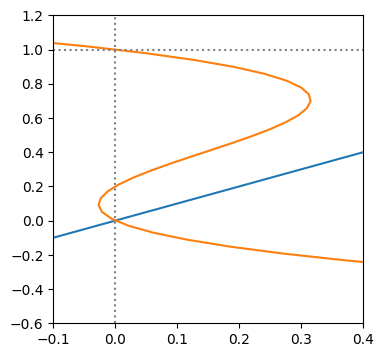

In [346]:
u_array = np.linspace(-1,3,100)
fig, ax = plt.subplots(1,1,figsize=(4,4))
ax.plot(u_array,u_array)
e = 1e-2 
a, b = (3, 0.2)
ax.plot(a*u_array*(u_array-b)*(1-u_array), u_array)
ax.axvline(0, c='grey', ls=':')
ax.axhline(1, c='grey', ls=':')
ax.set_xlim(-0.1,.4)
ax.set_ylim(-.6,1.2)

# Using sparse matrices

### Wave
Periodic boundary conditions, excitation in the middle.


In [335]:
T = 300
plot_n = 1000
N_x = 40
N_y = 40

N = N_x*N_y
y0 = np.zeros(2*N)
y0[819:822] = 0.5
y0[820-N_x] = 0.5
y0[820+N_x] = 0.5
e = 1e-2 
a, b = (3, 0.2)
Du=.1
#Dv=2

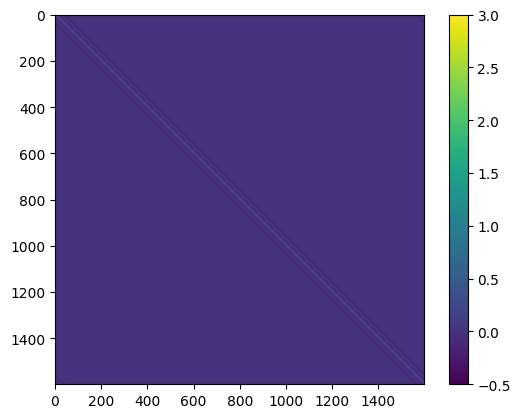

In [337]:

def graph_laplacian(N,M, boundary_condition="periodic"):

    num_nodes = N * M
    adj_matrix = lil_matrix((num_nodes, num_nodes))  # sparse adjacency matrix
    
    def node_index(i, j):
        return i * M + j

    for i in range(N):
        for j in range(M):
            idx = node_index(i, j)
            
            # Connect to 8 neighbors (including diagonals), weights according to Oono-Puri
            neighbors = [
                (i - 1, j, .5),     # up
                (i + 1, j, .5),     # down
                (i, j - 1, .5),     # left
                (i, j + 1, .5),     # right
                (i - 1, j - 1, .25), # top-left
                (i - 1, j + 1, .25), # top-right
                (i + 1, j - 1, .25), # bottom-left
                (i + 1, j + 1, .25)  # bottom-right
            ]
            
            for ni, nj, w in neighbors:
                if boundary_condition == "no-flux":
                    # Apply no-flux (Neumann) boundary conditions
                    if 0 <= ni < N and 0 <= nj < M:
                        adj_matrix[idx, node_index(ni, nj)] = w
                
                elif boundary_condition == "periodic":
                    # Apply periodic boundary conditions by wrapping indices
                    ni_wrapped = ni % N
                    nj_wrapped = nj % M
                    adj_matrix[idx, node_index(ni_wrapped, nj_wrapped)] = w

    degrees = np.array(adj_matrix.sum(axis=1)).flatten()
    degree_matrix = lil_matrix(np.diag(degrees))
    
    # Laplacian: L = D - A
    laplacian_matrix = degree_matrix - adj_matrix
    return laplacian_matrix


L=graph_laplacian(N_x, N_y)
Ld=L.todense()
plt.imshow(Ld)
plt.colorbar()


 Actually having a look at this nice review : https://arxiv.org/pdf/2404.11403
They don't introduce noise and Philipp says we should not put it.
Instead it is apparently necessary to introduce diffusion on the slow variable. Problem is that there is no directed mapping between their equations and ours: Philip says to first try with ours and if it doesn't work we can try with their and change the equations in the main text.

In [338]:
#the FHN equations would become
def FHN_graph(t, y):
    print(t,end='\r')
    u = y[:N]
    v = y[N:]

    
    du = a*u*(u-b)*(1-u) - Du*L.dot(u) - v 
    dv = e*(u-v)

    return np.append(du,dv)

In [339]:
out = sp.integrate.solve_ivp(FHN_graph, (0, T), y0, t_eval=np.linspace(0, T, plot_n), method='BDF')

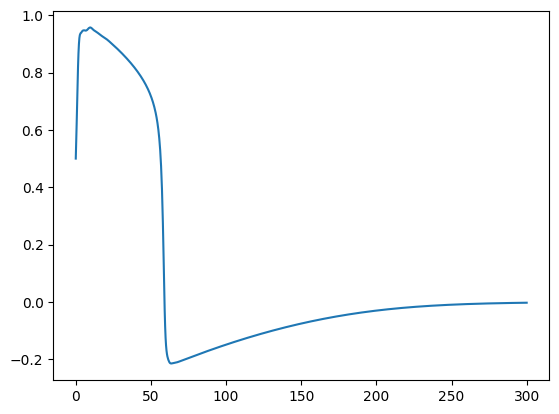

In [340]:
plt.plot(out['t'],out['y']
         [820,:].T)
##print(np.where(out['y'][N//2+1,:].T>0))

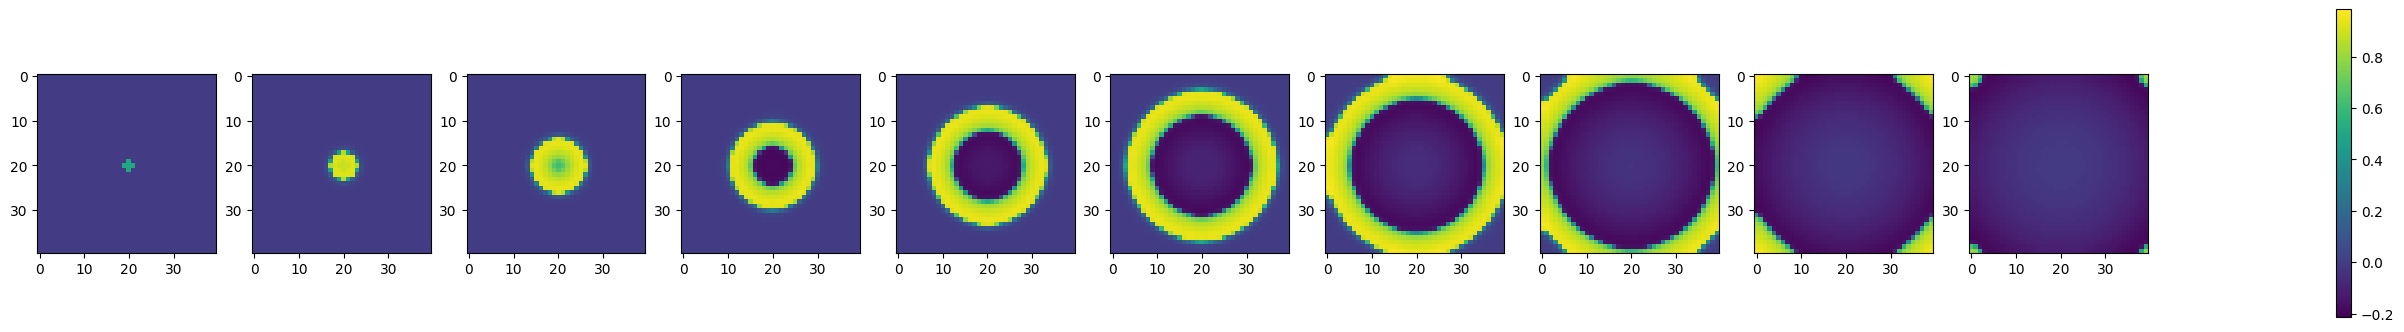

In [341]:
fig, axs = plt.subplots(1,11,figsize=(30,4))
min = out['y'].min()
max = out['y'].max()
for i, ax in enumerate(axs[:-1]):
    im = ax.imshow(out['y'][:N,int((i/len(axs))*len(out['t']))].reshape(N_x,N_y), vmin=min,vmax=max)
axs[-1].axis('off')
fig.colorbar(im, ax=axs[-1])

I guess this is quite cool cause we see the wave

## Spiral
no flux boundary condition. Excite all the left boundary, let the wave propagate up to the middle of the frame. Then initialise to zero the u variable in the lower half of the frame. The spiral should form. Otherwise, also with no flux boundary conditions we can exctite the left half of the frame, then initialise the lower half of the frame with a v variable in the refractory period. This however would require playing around with parameters.

Current problems: initialising it from a wave does not seem to work as for not too fast diffusion for some reason the wave does not reach the center of the frame. For bigger diffusion it is difficult to see anything at all. 

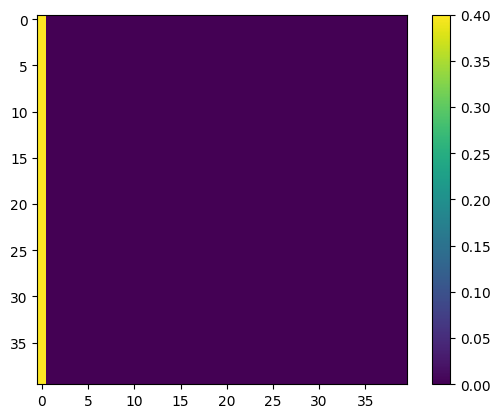

In [123]:

T = 200
plot_n = 100
N_x = 40
N_y = 40
N = N_x*N_y
y0 = np.zeros(2*N)

cells = np.arange(0,N*2,1)
for i in range(N):
    if i%N_x==0:
        y0[i]=0.4

#y0[N//2]=0.22
L=graph_laplacian(N_x, N_y, "no-flux")
e = 1e-2 
a, b = (3, 0.2)
Du=.1
#Dv=1
y=y0[:N].reshape(N_x, N_y)
plt.imshow(y)
plt.colorbar()

In [124]:
out = sp.integrate.solve_ivp(FHN_graph, (0, T), y0, t_eval=np.linspace(0, T, plot_n), method='BDF')

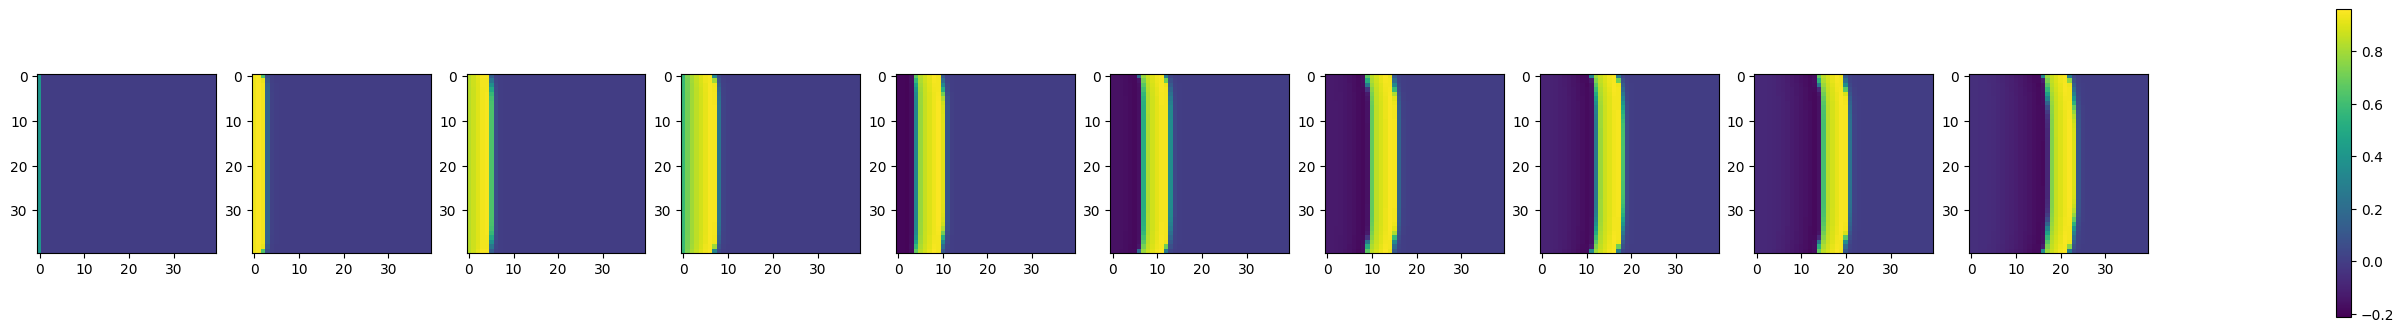

In [125]:
fig, axs = plt.subplots(1,11,figsize=(30,4))
min = out['y'].min()
max = out['y'].max()
for i, ax in enumerate(axs[:-1]):
    im = ax.imshow(out['y'][:N,int((i/len(axs))*len(out['t']))].reshape(N_x,N_y), vmin=min,vmax=max)
axs[-1].axis('off')
fig.colorbar(im, ax=axs[-1])

# 

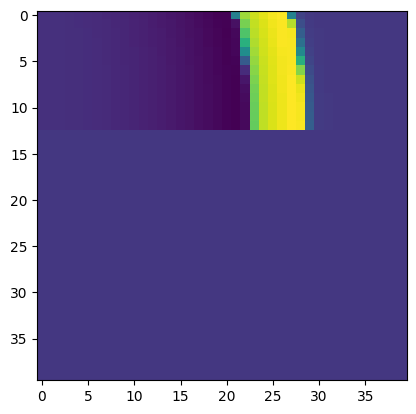

In [131]:
init=out['y'][:,-1]
y1 = init[:N].reshape(N_x, N_y)

y1[N_x//3:, :] = 0
plt.imshow(y1)
init[:N] = y1.flatten()
plot_n=100


In [132]:
plot_n=100
T2=700
out2 = sp.integrate.solve_ivp(FHN_graph, (0, T2), init, t_eval=np.linspace(0, T2, plot_n), method='BDF')

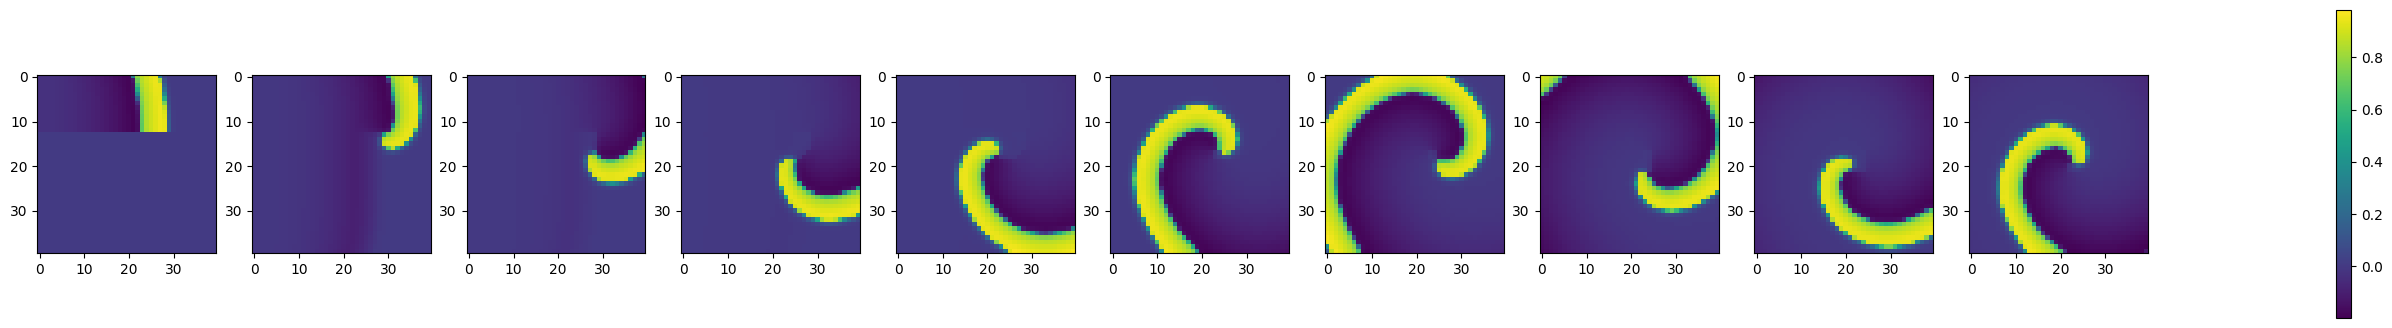

In [133]:
fig, axs = plt.subplots(1,11,figsize=(30,4))
min = out2['y'].min()
max = out2['y'].max()
for i, ax in enumerate(axs[:-1]):
    im = ax.imshow(out2['y'][:N,int((i/len(axs))*len(out['t']))].reshape(N_x,N_y), vmin=min,vmax=max)
axs[-1].axis('off')
fig.colorbar(im, ax=axs[-1])

## Parlitz spiral protocol

In his book he uses excitation at t=0 of a vertical stripe and at t=300 of an horizontal one. Then he lets them collide and form spirals. Uses Du=1. Problem: his system is super big. 

## Spatiotemporal chaos
it is unclear whether we can get it with FHN. Parlitz in his book uses the Aliev-Panfilov model to obtain it: 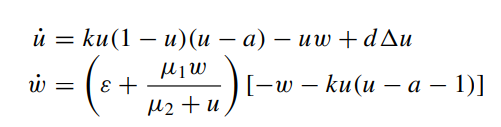
He then initialises a single spiral wave (how?) with parameters 
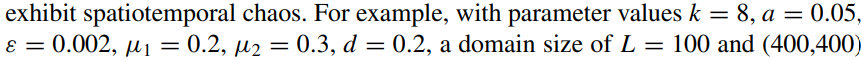

## Brain

In [325]:
#random network implementation
import random
import networkx as nx
#if we want a ER graph: Johannes says that this is what we find in literature
# for N=10000 we should choose k=100-1000 k=mean degree
def random_graph(N, k):

    p = k / (N - 1)
    
    G = nx.erdos_renyi_graph(N, p, directed=True)
    # Random weight between 0 and 1:at the moment we stick with excitatory, then maybe we'll also
    #put inhibition. At the moment we stick with random connections with fixed weight but we could also do rd weight
    for u, v in G.edges():
        G[u][v]['weight'] = np.random.uniform(0, 1)*J 
        # Get the adjacency matrix in sparse format
    adj_matrix = nx.adjacency_matrix(G, weight='weight')
    
    return adj_matrix
N = 100
k=10
c=.5
J=0.21/(k*c)  #defines the strength of the connection. 0.21 should be the threshold for excitation
L=random_graph(N,k)

In [326]:
T = 50
plot_n = 10
y0 = np.zeros(2*N)
#y0[N//2] = 0.22
e = 1e-1 
a, b = (3, 0.2)
D=0.1 #should be just above the threshold, is the noise strength


### For noise strength:
If the perturbations of an excitable system are due to noise the
system is now and then kicked above threshold and excursions occur randomly. For
noise amplitudes close to the threshold, however, this happens in a relatively regular
manner resembling a periodic motion (to some extent). This phenomenon is called
coherence resonance

### For parameters used by FH for neuron model:
A.S. Pikovsky, J. Kurths, Coherence resonance in a noise-driven excitable system. Phys. Rev.
Lett. 78, 775–778 (1997)
### For parameters for stochastic resonance
https://journals.aps.org/prl/pdf/10.1103/PhysRevLett.78.775

Problem is that they all use a different version of FHN equations (i.e. simplifying them)

Johannes also says that for neurons we should add a time delay



In [327]:
#the FHN equations with noise and time delay
from collections import deque
u_history = deque(maxlen=5) #here I consider a time delay of 3 integration timesteps (duration AP)
#I have put noise in the fast variable as in this way we can make a parallel with an "external input"


def FHN_graph(dy, y, p, t):
    print(t,end='\r')
    u = y[:N]
    v = y[N:]

    u_history.append(u.copy())

    # Use u from 3 time steps ago if available, otherwise use the current u
    if len(u_history) < 5:
        u_delayed = np.zeros(N)
    else:
        u_delayed = u_history[0]
    

    
    for i in range(len(dy)):
        dif = 0
        for j in range(len(u)):
            dif = L[i,j]*u[j]
        dy[i] = a*u[i]*(u[i]-b)*(1-u[i]) +dif - v[i]
        dy[i+N] = e*(u[i]-v[i])

def FHN_graph_noise(dy, y, p, t):
    dy[:N] = D
    dy[N:] = 0

T = 50
plot_n = 10

In [328]:
def FHN_graph(y, t):
    print(t,end='\r')
    u = y[:N]
    v = y[N:]
    
    du = a*u*(u-b)*(1-u) + L.dot(u) - v 
    dv = e*(u-v)

    return np.append(du,dv)

def FHN_graph_noise(y, t):
    noise = D*np.ones((2*N))
    noise[N:] = 0
    return np.diag(noise)

T = 500
plot_n = 3000

In [329]:
sol = sde.itoint(FHN_graph,FHN_graph_noise, y0, np.linspace(0,T, plot_n))

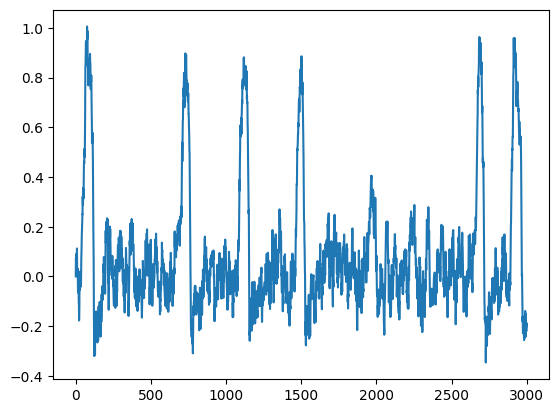

In [330]:
plt.plot(sol[:,0])

In [331]:
u_sol = sol[:,:N].T  # u over time
v_sol = sol[:,N:].T  # v over time

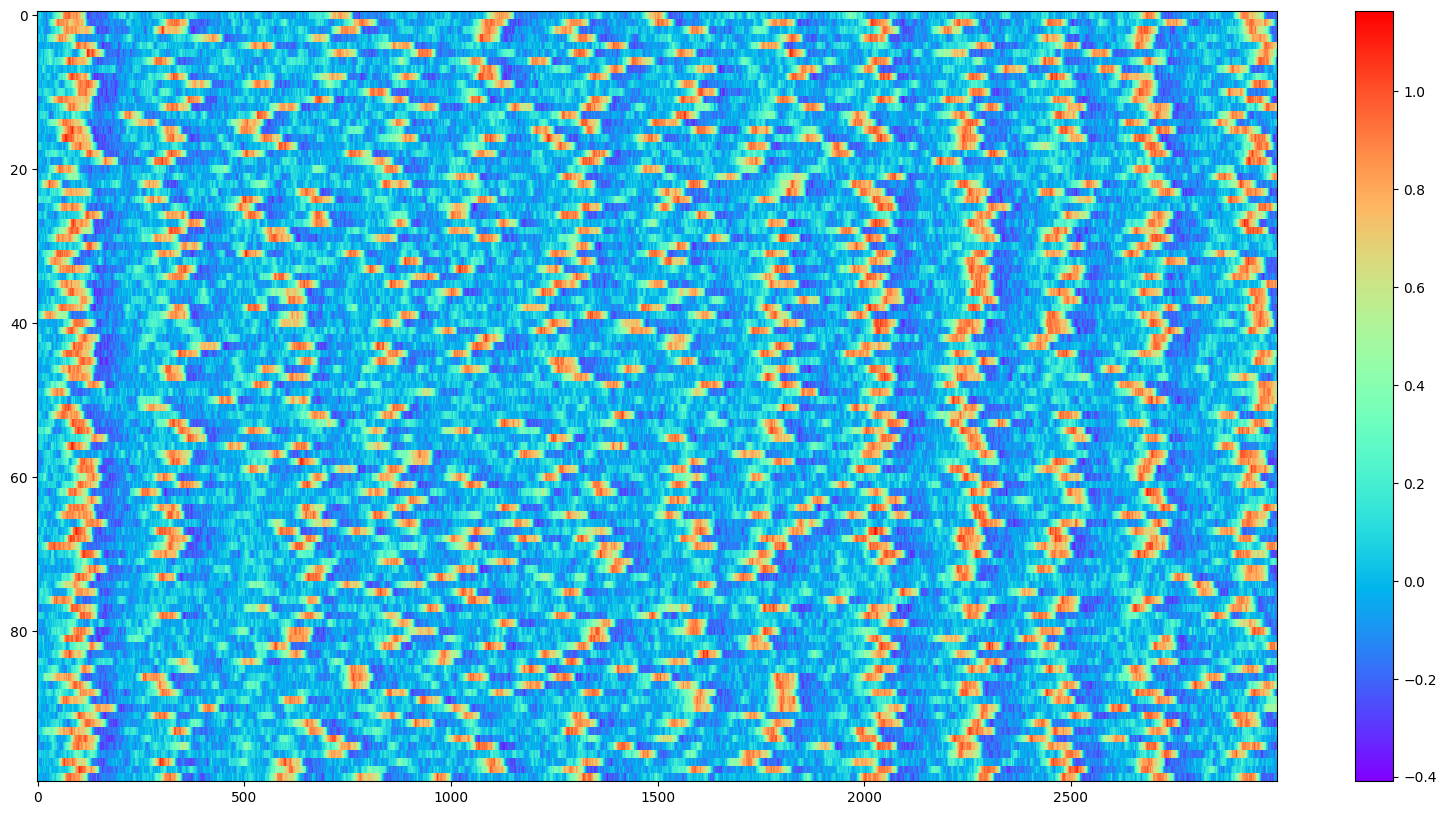

In [334]:
fig, ax = plt.subplots(1,1, figsize=(20, 10))
# heatmap with 
im = ax.imshow(u_sol, aspect='auto', cmap='rainbow', interpolation='none')

# plot colorbar
cbar = fig.colorbar(im, ax=ax)


## Below: without coupling

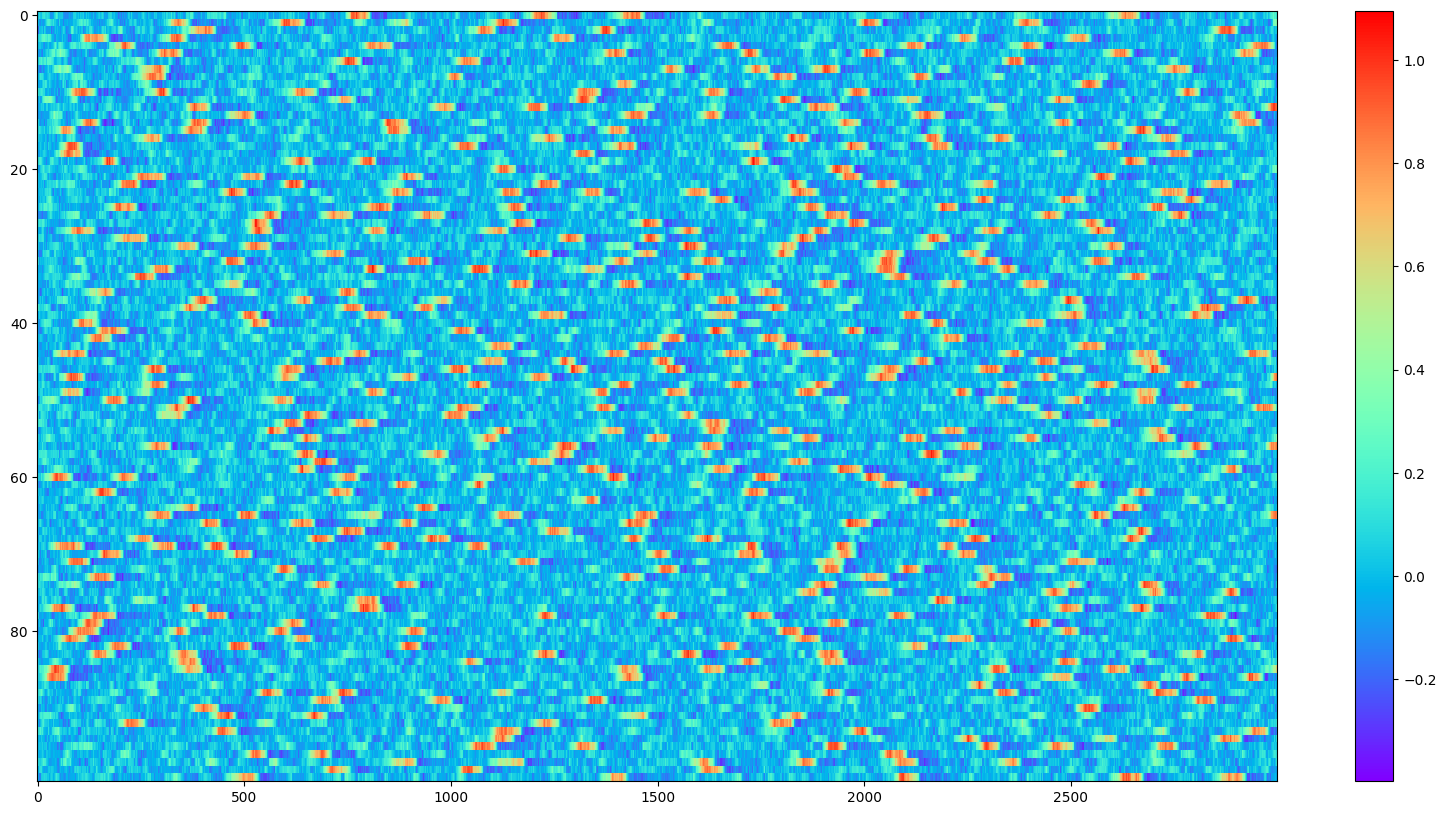

In [324]:
fig, ax = plt.subplots(1,1, figsize=(20, 10))
# heatmap with 
im = ax.imshow(u_sol, aspect='auto', cmap='rainbow', interpolation='none')

# plot colorbar
cbar = fig.colorbar(im, ax=ax)